In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install rouge-score sentence-transformers scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.3 MB/s eta 0:00:00:00:0100:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3b156e110703a138fdedf46dcdcd89b317400214d7fa8521254b315ab596f958
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
  Attempting uninstal

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer

2025-04-11 03:22:22.698181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744341742.875428      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744341742.924608      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Collect input text and summary preferences
print("Provide a main text to summarize and rank its sentences using k-NN:")
example_text = input("Enter your main text (multiple sentences): ")

Provide a main text to summarize and rank its sentences using k-NN:


Enter your main text (multiple sentences):  The morning sun crept over the horizon, casting a warm golden glow across the quiet valley. Dew clung to the grass, sparkling like tiny diamonds in the early light. A gentle breeze stirred the leaves, whispering secrets only the trees could understand. Birds began their daily chorus, filling the air with a symphony of trills and chirps. In the distance, a stream gurgled softly, its waters carving a patient path through ancient stones. The world felt alive, yet serene, as if time itself had paused to savor the moment. A lone deer stepped cautiously from the forest, its ears twitching at the faintest sounds. It nibbled on tender shoots, unaware of the fox watching from the shadows. The fox, sleek and silent, calculated its next move with practiced precision. Nature, in all its beauty, was a delicate balance of peace and survival. High above, clouds drifted lazily, painting the sky with streaks of pink and orange. The air carried the earthy scen

In [6]:
print("\nConfigure your summary:")
num_sentences = int(input("Enter number of sentences for summary (e.g., 3, or 0 for all): "))
num_keywords = int(input("Enter number of keywords (e.g., 5, or 0 for none): "))
format_choice = input("Output format (paragraph/bullet): ").lower().strip()
representation_choice = input("Sentence representation (tfidf/embedding): ").lower().strip()


Configure your summary:


Enter number of sentences for summary (e.g., 3, or 0 for all):  8
Enter number of keywords (e.g., 5, or 0 for none):  4
Output format (paragraph/bullet):  bullet
Sentence representation (tfidf/embedding):  tfidf


In [8]:
# Process text
sentences = sent_tokenize(example_text)
if len(sentences) < 2:
    print("Please provide at least two sentences to summarize.")
    exit()

# Calculate word frequencies for keywords and compatibility with original approach
stop_words = set(nltk.corpus.stopwords.words('english'))
all_words = word_tokenize(example_text.lower())
filtered_words = [w for w in all_words if w.isalnum() and w not in stop_words]
word_freq = Counter(filtered_words)

# Create word frequency table
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

print("\nWord Frequency Table (across entire text):")
print(word_freq_df.to_string(index=False))


Word Frequency Table (across entire text):
        Word  Frequency
      valley          3
         fox          3
         sun          2
       world          2
        deer          2
       every          2
         air          2
        tiny          2
     shadows          2
      nearby          1
      darted          1
        tree          1
       claws          1
  scratching          1
        bark          1
        life          1
    unfolded          1
   countless          1
       small          1
     moments          1
         one          1
      thread          1
    tapestry          1
      seemed          1
    squirrel          1
       peace          1
        high          1
      clouds          1
     drifted          1
      lazily          1
    painting          1
         sky          1
     streaks          1
        pink          1
         day          1
     carried          1
      earthy          1
       scent          1
        moss        

In [9]:
# Sentence vectorization and k-NN ranking
if representation_choice == 'embedding':
    # Use sentence embeddings for semantic similarity
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    sentence_vectors = embedder.encode(sentences)
else:
    # Use TF-IDF for lexical similarity
    vectorizer = TfidfVectorizer(stop_words='english')
    sentence_vectors = vectorizer.fit_transform(sentences).toarray()

# Compute centroid (mean vector of all sentences)
centroid = np.mean(sentence_vectors, axis=0).reshape(1, -1)

In [10]:
# Apply k-NN to find sentences closest to centroid
k = min(len(sentences), max(1, num_sentences))  # Ensure k is valid
knn = NearestNeighbors(n_neighbors=k, metric='cosine')
knn.fit(sentence_vectors)
distances, indices = knn.kneighbors(centroid)

# Create sentence ranking table based on k-NN distances
ranking_df = pd.DataFrame({
    'Sentence': [sentences[i] for i in indices[0]],
    'Distance to Centroid': distances[0],
    'Rank': range(1, len(indices[0]) + 1)
})
# Normalize distances to a similarity score (0 to 1, lower distance = higher similarity)
max_distance = max(distances[0]) if max(distances[0]) > 0 else 1
ranking_df['Similarity Score'] = [1 - (d / max_distance) for d in distances[0]]

print("\nSentence Ranking Table (ordered by k-NN similarity to centroid):")
print(ranking_df[['Sentence', 'Distance to Centroid', 'Similarity Score']].to_string(index=False))


Sentence Ranking Table (ordered by k-NN similarity to centroid):
                                                                                     Sentence  Distance to Centroid  Similarity Score
                   It nibbled on tender shoots, unaware of the fox watching from the shadows.              0.721324          0.058615
                   As the sun climbed higher, shadows shortened, and the world grew brighter.              0.722548          0.057017
  The morning sun crept over the horizon, casting a warm golden glow across the quiet valley.              0.736501          0.038808
                The fox, sleek and silent, calculated its next move with practiced precision.              0.743901          0.029151
                The fox, disappointed but undeterred, slunk away to seek another opportunity.              0.745645          0.026874
     The valley seemed to hum with an unspoken rhythm, a pulse that connected every creature.              0.753425          0.016

In [11]:
# Function to extract keywords
def get_important_keywords(text, num_keywords):
    if num_keywords <= 0:
        return []
    words = word_tokenize(text.lower())
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_words = [w for w in words if w.isalnum() and w not in stop_words]
    word_freq = Counter(filtered_words)
    sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    return [word for word, _ in sorted_words][:num_keywords]

In [12]:
# Generate extractive summary
if num_sentences <= 0 or num_sentences >= len(sentences):
    summary_sentences = sentences
else:
    summary_sentences = ranking_df['Sentence'].head(num_sentences).tolist()

summary_text = " ".join(summary_sentences)
keywords = get_important_keywords(summary_text, num_keywords)

In [13]:
# Format the summary
if format_choice == 'bullet':
    formatted_summary = "\n".join([f"- {s}" for s in summary_sentences])
    if keywords:
        formatted_summary += "\nKeywords: " + ", ".join(keywords)
else:
    formatted_summary = summary_text
    if keywords:
        formatted_summary += " (Keywords: " + ", ".join(keywords) + ")"

print("\nExtractive Summary (based on k-NN ranking):")
print(formatted_summary)


Extractive Summary (based on k-NN ranking):
- It nibbled on tender shoots, unaware of the fox watching from the shadows.
- As the sun climbed higher, shadows shortened, and the world grew brighter.
- The morning sun crept over the horizon, casting a warm golden glow across the quiet valley.
- The fox, sleek and silent, calculated its next move with practiced precision.
- The fox, disappointed but undeterred, slunk away to seek another opportunity.
- The valley seemed to hum with an unspoken rhythm, a pulse that connected every creature.
- And so, the valley continued its eternal dance, where every dawn brought new stories to tell.
- The world felt alive, yet serene, as if time itself had paused to savor the moment.
Keywords: fox, valley, shadows, sun


In [14]:
# Compute Cosine Similarity using TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform([example_text, summary_text])
cosine_similarity_score = np.dot(tfidf_matrix[0], tfidf_matrix[1].T).toarray()[0][0] / (
    np.linalg.norm(tfidf_matrix[0].toarray()) * np.linalg.norm(tfidf_matrix[1].toarray()) + 1e-10
)

print("\nCosine Similarity Evaluation (between full text and summary):")
print(f"Cosine Similarity Score: {cosine_similarity_score:.4f}")


Cosine Similarity Evaluation (between full text and summary):
Cosine Similarity Score: 0.5258


In [15]:
# Save tables and summary to files
word_freq_df.to_csv('word_frequency_table.csv', index=False)
ranking_df.to_csv('sentence_ranking_table.csv', index=False)
with open('extractive_summary.txt', 'w') as f:
    f.write(formatted_summary)

print("Word frequency table saved to 'word_frequency_table.csv'")
print("Sentence ranking table saved to 'sentence_ranking_table.csv'")
print("Summary saved to 'extractive_summary.txt'")

Word frequency table saved to 'word_frequency_table.csv'
Sentence ranking table saved to 'sentence_ranking_table.csv'
Summary saved to 'extractive_summary.txt'


Heatmap saved to 'similarity_heatmap.png'


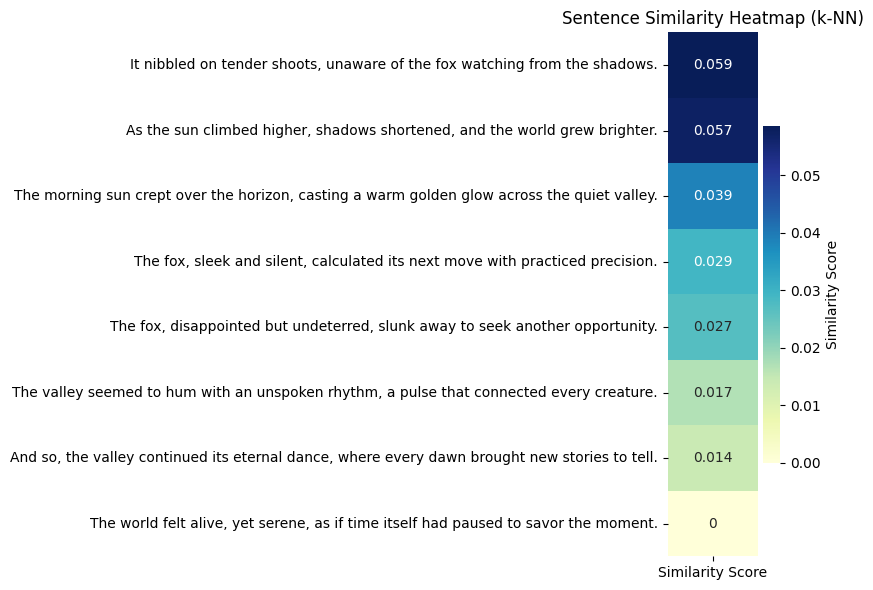

In [16]:
# Generate vertical heatmap for similarity scores
plt.figure(figsize=(8, len(sentences) * 0.3))
sns.heatmap(ranking_df[['Similarity Score']], annot=True, cmap='YlGnBu', 
            yticklabels=ranking_df['Sentence'].tolist(), xticklabels=['Similarity Score'], 
            cbar_kws={'label': 'Similarity Score'})
plt.title('Sentence Similarity Heatmap (k-NN)')
plt.xlabel('')
plt.tight_layout()
plt.savefig('similarity_heatmap.png')
print("Heatmap saved to 'similarity_heatmap.png'")
plt.show()

Bar graph saved to 'similarity_bar_graph.png'


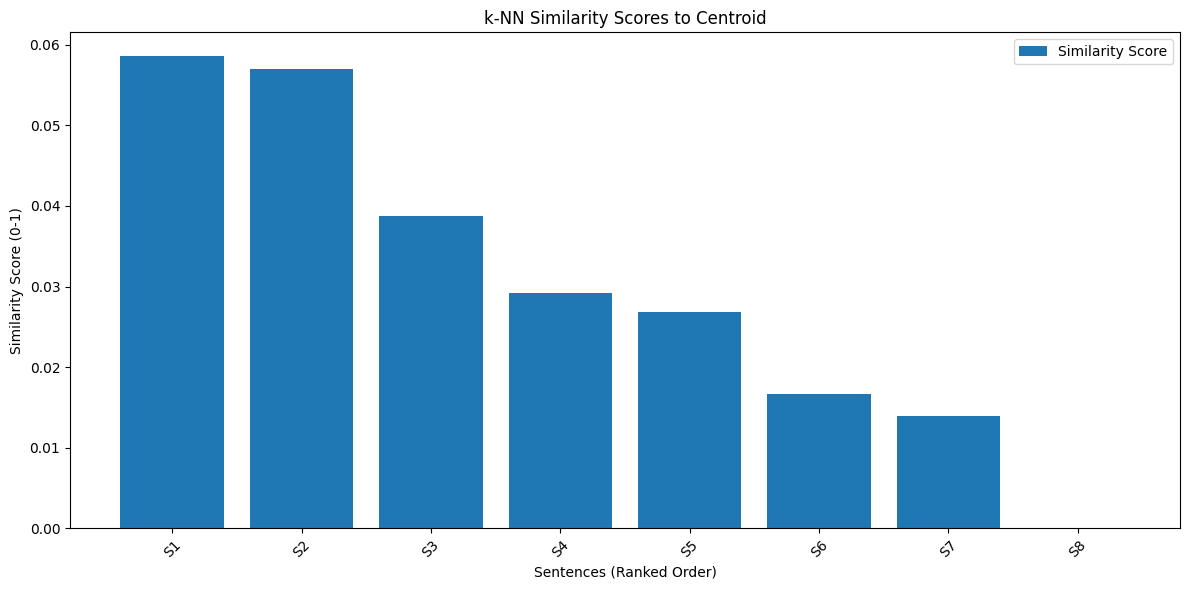

In [17]:
# Bar graph for similarity scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(ranking_df)), ranking_df['Similarity Score'], color='#1f77b4', label='Similarity Score')
plt.xlabel('Sentences (Ranked Order)')
plt.ylabel('Similarity Score (0-1)')
plt.title('k-NN Similarity Scores to Centroid')
plt.xticks(range(len(ranking_df)), [f'S{i+1}' for i in range(len(ranking_df))], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('similarity_bar_graph.png')
print("Bar graph saved to 'similarity_bar_graph.png'")
plt.show()

Cosine Similarity bar graph saved to 'cosine_similarity_bar_graph.png'


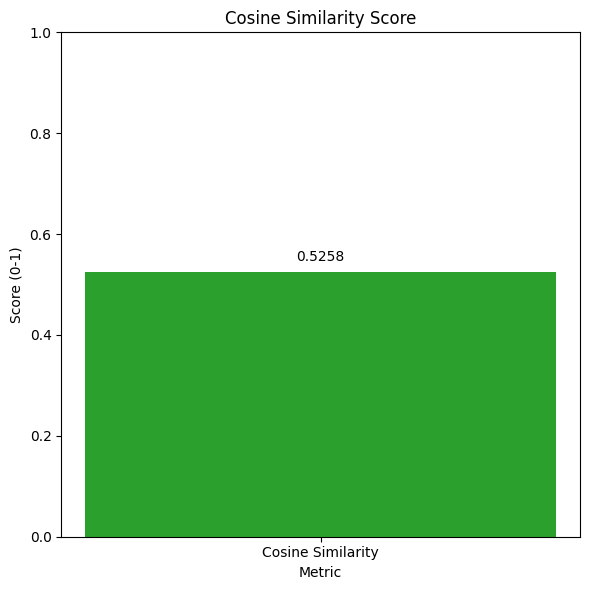

In [18]:
# Bar graph for Cosine Similarity score
plt.figure(figsize=(6, 6))
plt.bar(['Cosine Similarity'], [cosine_similarity_score], color='#2ca02c')
plt.xlabel('Metric')
plt.ylabel('Score (0-1)')
plt.title('Cosine Similarity Score')
plt.ylim(0, 1)
plt.text(0, cosine_similarity_score + 0.02, f'{cosine_similarity_score:.4f}', ha='center')
plt.tight_layout()
plt.savefig('cosine_similarity_bar_graph.png')
print("Cosine Similarity bar graph saved to 'cosine_similarity_bar_graph.png'")
plt.show()